In [1]:
# Bibliotecas necessárias
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Baixar e instalar o pacote SHAP (não é incluido no Google Colab)
!pip install -q shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 2.7 MB/s eta 0:00:00


In [2]:
# Carregar Google Drive
from google.colab import drive
import os

# Montar o diretório do projeto
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/RF_Salvador')

Mounted at /content/drive


In [18]:
# Carregar dados meterológicos/pré-processamento
met = pd.read_csv('POA_Met.csv', sep=';', index_col=False)

met.dropna(inplace=True)

if pd.api.types.is_string_dtype(met['hora']):
  met['hora'] = met['hora'].str.strip()
else:
  met['hora'] = met['hora'].astype(str).str.zfill(4)  # Adicionar zeros à esquerda

met['data'] = pd.to_datetime(met['data'])

met['datetime'] = pd.to_datetime(met['data'].dt.strftime('%Y-%m-%d') + met['hora'], format='%Y-%m-%d%H%M')

met['rad_solar'] = met['rad_solar'].where(met['rad_solar'] >= 0, 0)

print(met.head())
print(met.shape)

        data  hora  prec_total  pressao_atm  rad_solar  temperatura  \
0 2017-01-01  0000         0.0       1000.7        0.0         26.0   
1 2017-01-01  0100         0.0       1001.4        0.0         25.5   
2 2017-01-01  0200         0.0       1002.1        0.0         25.1   
3 2017-01-01  0300         0.0       1002.6        0.0         23.7   
4 2017-01-01  0400         0.0       1002.4        0.0         23.0   

   temp_max_hr  temp_min_hr  umid_relativa  dir_vento  veloc_vento  \
0         26.5         25.9           78.0      341.0          2.1   
1         26.0         25.5           77.0      323.0          1.5   
2         25.5         25.0           79.0      323.0          0.7   
3         25.0         23.7           87.0      150.0          0.4   
4         23.7         23.0           90.0       74.0          0.2   

             datetime  
0 2017-01-01 00:00:00  
1 2017-01-01 01:00:00  
2 2017-01-01 02:00:00  
3 2017-01-01 03:00:00  
4 2017-01-01 04:00:00  
(34080, 

In [19]:
# Carregar dados do DataSUS/pré-processamento
datasus = pd.read_csv('POA_DataSUS.csv', delimiter=',', index_col=False)

datasus['data'] = datasus[['ANO', 'MES', 'DIA']].astype(str).agg(','.join, axis=1)

datasus['data'] = pd.to_datetime(datasus['data'], format='%Y,%m,%d')

datasus.drop(columns=['MUNIC_RES', 'NASC', 'ANO', 'MES', 'DIA'], inplace=True)

datasus.rename(columns={'SEXO': 'sexo',
                        'DIAG_CID': 'diag_cid',
                        'IDADE': 'idade'}, inplace=True)

datasus['diag_freq'] = datasus.groupby('data')['diag_cid'].transform('count')

datasus = datasus.drop_duplicates('data')

print(datasus.head())
print(datasus.shape)

# Opcional - Salvar matriz como .csv
# datasus.to_csv("Matriz_DataSUS.csv", index=False)

   sexo  diag_cid  idade       data  diag_freq
0     3         0      5 2019-12-15          6
1     3         0      1 2020-03-26         15
2     3        10     66 2019-12-20         15
3     3        19     75 2020-03-09         13
4     3        30      3 2020-05-01         10
(842, 5)


In [20]:
# Processamento dos dados meteorológicos, cálculo de médias e cumulativos diários
def deg_to_rad(degrees):
    return np.deg2rad(degrees)

def rad_to_deg(radians):
    return np.rad2deg(radians)

met_daily = met.resample('D', on='data').agg({
    'pressao_atm': 'mean',
    'temperatura': 'mean',
    'umid_relativa': 'mean',
    'dir_vento': lambda x: (rad_to_deg(np.arctan2(np.mean(np.sin(deg_to_rad(x)) * met.loc[x.index, 'veloc_vento']),
                                                    np.mean(np.cos(deg_to_rad(x)) * met.loc[x.index, 'veloc_vento']))) + 360) % 360,
    'veloc_vento': 'mean',
    'prec_total': 'sum',
    'rad_solar': lambda x: x.sum() / 1e3, # KJ to MJ
    'temp_max_hr': 'max',
    'temp_min_hr': 'min'
})


met_daily = met_daily.reset_index()

met_daily.rename(columns={'temperatura': 'temp_med_dia',
                        'rad_solar': 'dose',
                        'temp_max_hr': 'temp_max_dia',
                        'temp_min_hr': 'temp_min_dia'}, inplace=True)

met_daily['dia_juliano'] = met_daily['data'].dt.dayofyear
met_daily['dia_semana'] = met_daily['data'].dt.dayofweek

print(met_daily.head())
print(met_daily.shape)

        data  pressao_atm  temp_med_dia  umid_relativa   dir_vento  \
0 2017-01-01  1002.537500     27.350000      75.916667  277.642821   
1 2017-01-02  1005.383333     27.241667      79.791667  132.099916   
2 2017-01-03  1004.400000     27.475000      75.791667   97.473276   
3 2017-01-04  1002.100000     25.208333      85.666667  223.497211   
4 2017-01-05  1003.875000     24.720833      86.500000  259.035638   

   veloc_vento  prec_total       dose  temp_max_dia  temp_min_dia  \
0     1.595833         0.0  27.588722          33.0          22.4   
1     1.312500         0.0  19.698622          31.6          24.3   
2     1.450000         0.0  25.897676          34.6          22.5   
3     1.829167        78.8  19.298059          33.3          20.9   
4     1.091667        10.8  19.248597          31.2          21.5   

   dia_juliano  dia_semana  
0            1           6  
1            2           0  
2            3           1  
3            4           2  
4            5     

In [21]:
# Variáveis categóricas

# Adicionar coluna com a estação do ano (one-hot)
def map_to_season(month):
    if month in [12, 1, 2]:    # Verão: Dez, Jan, Fev
        return 'verao'
    elif month in [3, 4, 5]:   # Outono: Mar, Abr, Maio
        return 'outono'
    elif month in [6, 7, 8]:   # Inverno: Ju, Jul, Ago
        return 'inverno'
    elif month in [9, 10, 11]: # Verão: Set, Out, Nov
        return 'primavera'

met_daily['est'] = met_daily['data'].dt.month.map(map_to_season)

met_daily = pd.get_dummies(met_daily, columns=['est'], drop_first=False, dtype=float)

# Direção do vento em setores (one-hot)
def map_to_wind_direction(degrees):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    boundaries = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    for i in range(len(boundaries) - 1):
        if boundaries[i] <= degrees < boundaries[i + 1]:
            return directions[i]

met_daily['dir_vento'] = met_daily['dir_vento'].apply(map_to_wind_direction)

met_daily = pd.get_dummies(met_daily, columns=['dir_vento'], drop_first=False, dtype=float)

print(met_daily.head())
print(met_daily.shape)

        data  pressao_atm  temp_med_dia  umid_relativa  veloc_vento  \
0 2017-01-01  1002.537500     27.350000      75.916667     1.595833   
1 2017-01-02  1005.383333     27.241667      79.791667     1.312500   
2 2017-01-03  1004.400000     27.475000      75.791667     1.450000   
3 2017-01-04  1002.100000     25.208333      85.666667     1.829167   
4 2017-01-05  1003.875000     24.720833      86.500000     1.091667   

   prec_total       dose  temp_max_dia  temp_min_dia  dia_juliano  ...  \
0         0.0  27.588722          33.0          22.4            1  ...   
1         0.0  19.698622          31.6          24.3            2  ...   
2         0.0  25.897676          34.6          22.5            3  ...   
3        78.8  19.298059          33.3          20.9            4  ...   
4        10.8  19.248597          31.2          21.5            5  ...   

   est_primavera  est_verao  dir_vento_E  dir_vento_N  dir_vento_NE  \
0            0.0        1.0          0.0          0.0    

In [22]:
# União das as duas matrizes
merged_data = pd.merge(met_daily, datasus[['data', 'diag_freq']], on='data', how='inner')

merged_data.dropna(inplace=True)

print(merged_data.head())
print(merged_data.shape)

# Opcional - Salvar matriz como .csv
# merged_data.to_csv("Matriz_Meteorologia_FreqCID.csv", index=False)

        data  pressao_atm  temp_med_dia  umid_relativa  veloc_vento  \
1 2017-08-24  1010.366667     22.787500      74.875000     0.825000   
2 2017-09-28  1015.125000     18.412500      83.291667     2.483333   
3 2017-10-11  1007.071429     18.214286      99.571429     1.735714   
4 2017-10-23  1015.466667     16.125000      58.125000     1.504167   
5 2017-10-24  1012.775000     17.987500      70.291667     1.641667   

   prec_total       dose  temp_max_dia  temp_min_dia  dia_juliano  ...  \
1         0.0  16.096542          32.9          15.7          236  ...   
2         0.6   7.632255          20.3          16.8          271  ...   
3        28.4   1.189390          19.9          17.3          284  ...   
4         0.0  28.762974          21.7          11.4          296  ...   
5         0.0  26.071345          26.4          12.6          297  ...   

   est_verao  dir_vento_E  dir_vento_N  dir_vento_NE  dir_vento_NW  \
1        0.0          0.0          0.0           1.0      

In [23]:
# Adicionando um atraso de k dias nas variáveis independentes
merged_data_lagged = merged_data.copy()

lagged_column = 'diag_freq'
merged_data_lagged[lagged_column] = merged_data_lagged[lagged_column].shift(-5)

merged_data_lagged.dropna(inplace=True)

print(merged_data_lagged.head())

        data  pressao_atm  temp_med_dia  umid_relativa  veloc_vento  \
1 2017-08-24  1010.366667     22.787500      74.875000     0.825000   
2 2017-09-28  1015.125000     18.412500      83.291667     2.483333   
3 2017-10-11  1007.071429     18.214286      99.571429     1.735714   
4 2017-10-23  1015.466667     16.125000      58.125000     1.504167   
5 2017-10-24  1012.775000     17.987500      70.291667     1.641667   

   prec_total       dose  temp_max_dia  temp_min_dia  dia_juliano  ...  \
1         0.0  16.096542          32.9          15.7          236  ...   
2         0.6   7.632255          20.3          16.8          271  ...   
3        28.4   1.189390          19.9          17.3          284  ...   
4         0.0  28.762974          21.7          11.4          296  ...   
5         0.0  26.071345          26.4          12.6          297  ...   

   est_verao  dir_vento_E  dir_vento_N  dir_vento_NE  dir_vento_NW  \
1        0.0          0.0          0.0           1.0      

In [24]:
# Separar variáveis independentes e dependente
X = merged_data_lagged.drop(columns=['data', 'diag_freq'])
Y = merged_data_lagged['diag_freq']

# Reduzir Y para uma dimensão
Y = Y.values.ravel()

# Divisão entre amostras de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)

(661, 22)
(661,)


In [25]:
# Criar o regressor random forest
model = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=2,
                              min_samples_leaf=1, random_state=42, oob_score=True, n_jobs=-1, verbose=1)

# Treinar usando o conjunto de treino
model.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=1)

In [26]:
# Prever os preços usando o conjunto de teste
Y_pred = model.predict(X_test)

# Cálculo das métricas
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print('RMSE:', rmse)

mae = mean_absolute_error(Y_test, Y_pred)
print('MAE:', mae)

r2 = r2_score(Y_test, Y_pred)
print('R2', r2)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


RMSE: 7.905366123220903
MAE: 5.945084337349399
R2 0.3650600161755835


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


In [27]:
# Prever os preços usando o conjunto OOB
Y_oob = model.oob_prediction_

print(Y_train.shape)
print(Y_oob.shape)

# Cálculo das métricas
oob_rmse = np.sqrt(mean_squared_error(Y_train, Y_oob))
print("OOB RMSE:", oob_rmse)

oob_mae = mean_absolute_error(Y_train, Y_oob)
print("OOB MAE:", oob_mae)

oob_r2 = r2_score(Y_train, Y_oob)
print("OOB R2:", oob_r2)

(661,)
(661,)
OOB RMSE: 7.52893993409999
OOB MAE: 5.637806357108679
OOB R2: 0.30775358600656955


In [32]:
# Validação cruzada usando K-Fold com 5 folds
from sklearn.model_selection import KFold

X = merged_data_lagged.drop(columns=['data', 'diag_freq'])
Y = merged_data_lagged['diag_freq']

Y = Y.values.ravel()

model = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=2,
                              min_samples_leaf=1, oob_score=True, n_jobs=-1, verbose=0)

kf = KFold(n_splits=5, shuffle=True)

rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    rmse_scores.append(rmse)

    mae = mean_absolute_error(Y_test, Y_pred)
    mae_scores.append(mae)

    r2 = r2_score(Y_test, Y_pred)
    r2_scores.append(r2)

# Resumo das métricas
print('RMSE:', rmse_scores)
print('MAE:', mae_scores)
print('R2:', r2_scores)

RMSE: [7.1030521540823885, 7.177546065200299, 8.564135567126504, 7.675170455909935, 7.1071888335087525]
MAE: [5.365240963855422, 5.439132530120482, 6.382193939393939, 5.9729090909090905, 5.14619393939394]
R2: [0.4157629665163939, 0.24380866466096196, 0.24186268174890824, 0.3291657427134922, 0.40814501036784556]


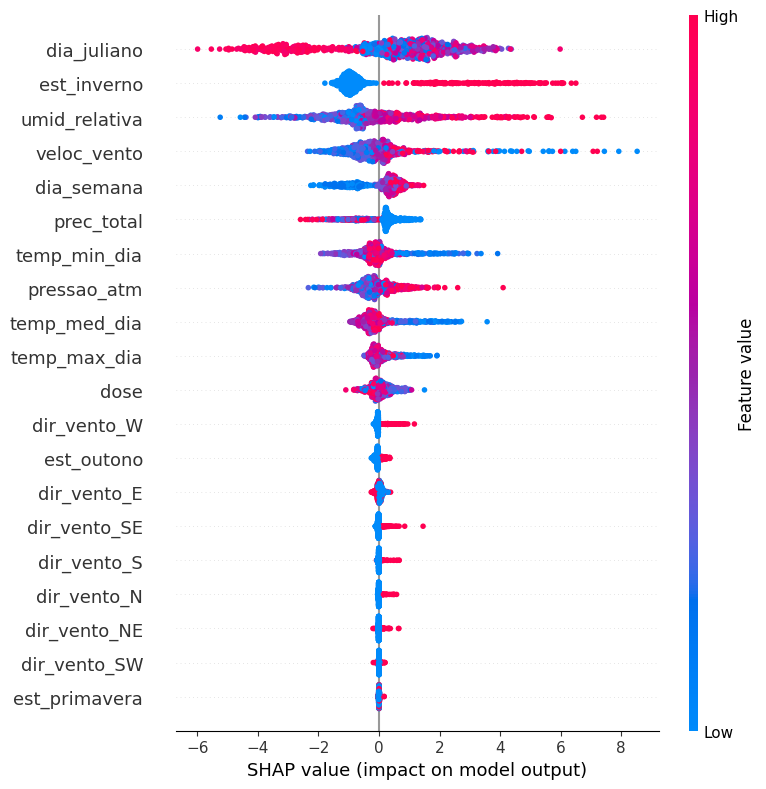

In [28]:
# Interpretação do modelo usando SHAP
explainer = shap.TreeExplainer(model)

# Cáculo dos valores SHAP
shap_values = explainer.shap_values(X)

# Visualização (resumo)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_size=[8, 8])

In [29]:
# Visualização ("force")
shap.plots.initjs()

shap.force_plot(explainer.expected_value, shap_values[270,:], X.iloc[270,:], feature_names=X.columns)

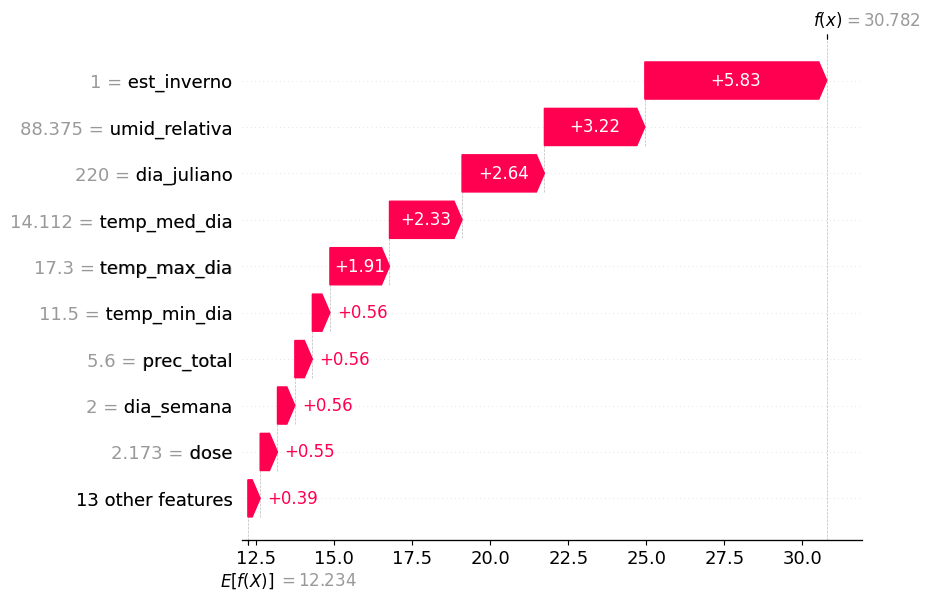

In [30]:
# Visualização ("waterfall")
explanation = shap.Explanation(shap_values[270], explainer.expected_value, X.iloc[270])

shap.plots.waterfall(explanation)

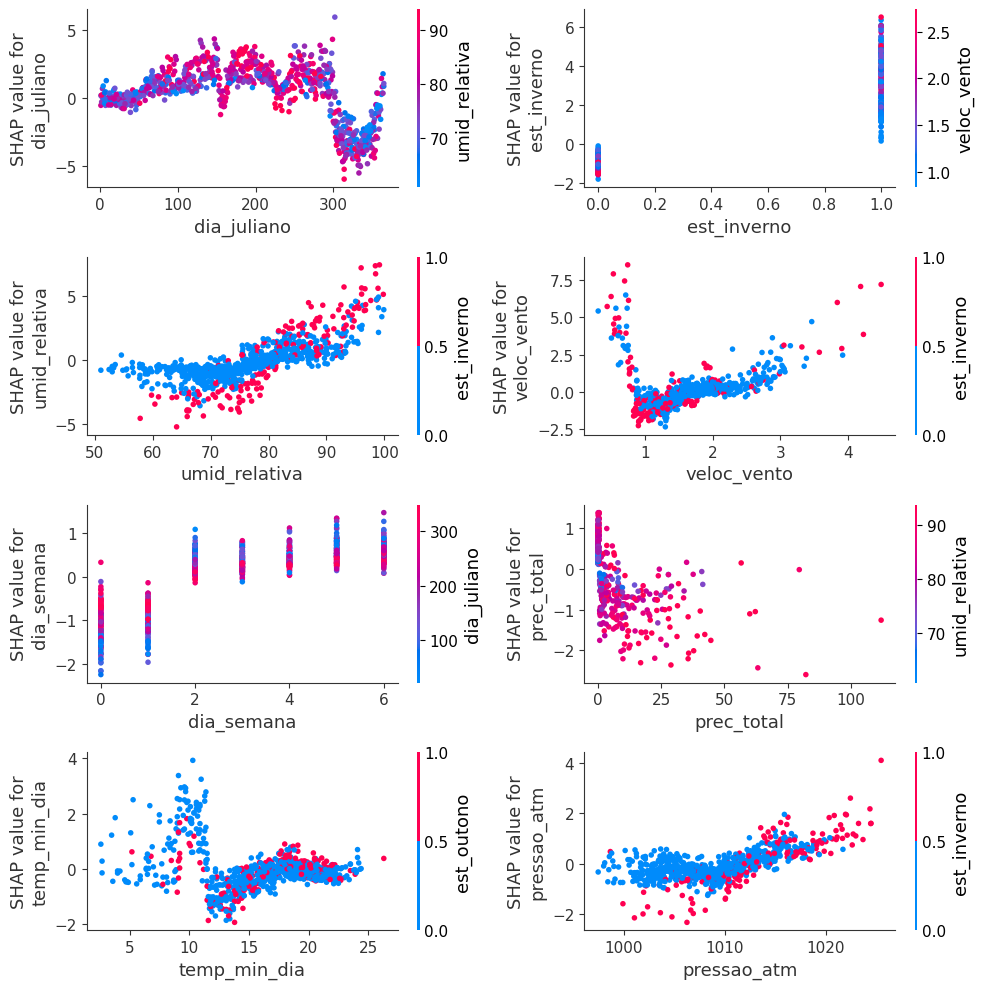

In [31]:
# Visualização (gráficos de dependência)

# Ordenar as variáveis por ordem de importância
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))[:8]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
axes = axes.ravel()

for i, col in enumerate(top_inds):
    shap.dependence_plot(top_inds[i], shap_values, X, ax=axes[i], feature_names=X.columns, show=False)

plt.tight_layout()
plt.show()